In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cetpbeim
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cetpbeim
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'segment_anything' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'segment_anything'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36635 sha256=b23efa4d8c8c0d73f9b79f3

In [4]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 10.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.0
    Uninstalling numpy-2.3.0:
      Successfully uninstalled numpy-2.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]


In [14]:
import cv2
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import base64
import requests
import chromadb
from sentence_transformers import SentenceTransformer
import json



In [2]:
IMAGE_PATH = "img3.jpg"  # Your food image
SAM_CHECKPOINT = "sam_vit_b_01ec64.pth"  # Path to downloaded checkpoint
SEGMENTED_OUTPUT_PATH = "segmented_overlay.jpg"
CHROMA_COLLECTION_NAME = "food_macros"

In [3]:
# ---------- Step 1: Load and prepare image ----------
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [4]:
# ---------- Step 2: Load SAM model ----------
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=SAM_CHECKPOINT)
sam.to(device="cuda" if torch.cuda.is_available() else "cpu")

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [5]:
# ---------- Step 3: Generate segmentation masks ----------
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image_rgb)

In [6]:
# ---------- Step 4: Sort and visualize masks ----------
# Sort masks by area (largest to smallest)
masks = sorted(masks, key=lambda x: x['area'], reverse=True)

overlay_image = image_rgb.copy()

for i, mask in enumerate(masks[:10]):  # Blend only top 10 masks
    segmentation = mask["segmentation"]
    color = np.random.randint(0, 255, size=3)
    overlay_image[segmentation] = 0.6 * overlay_image[segmentation] + 0.4 * color

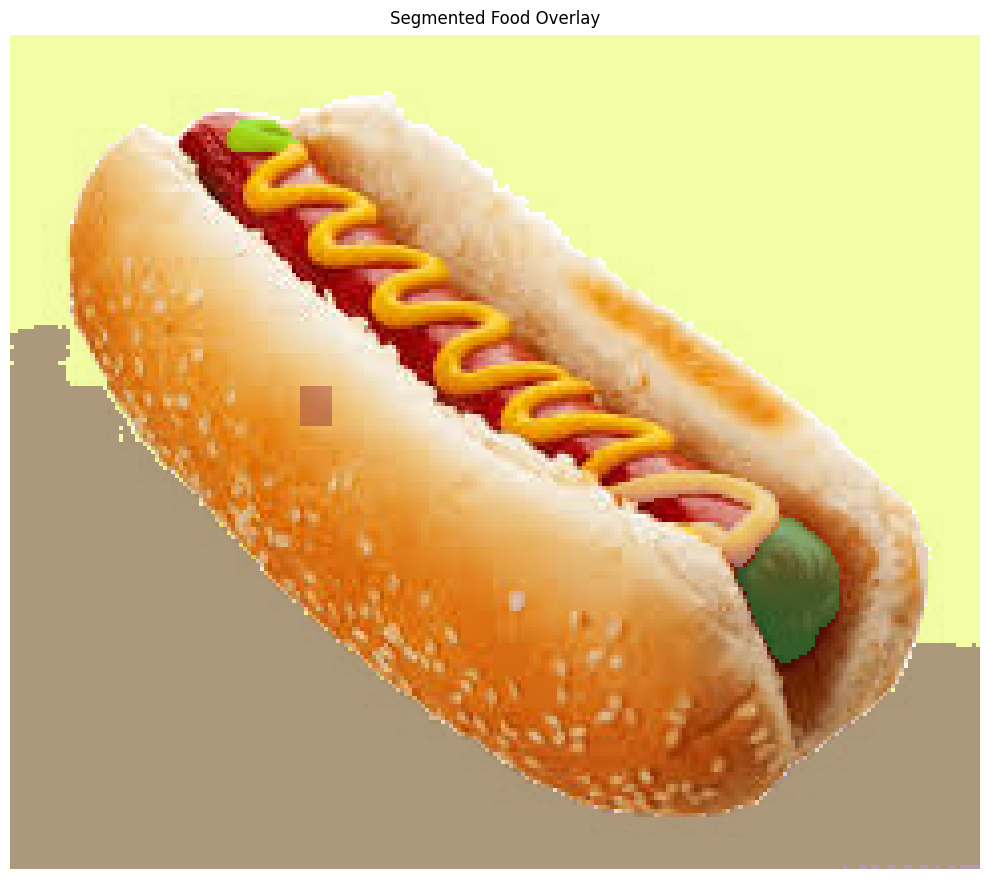

In [7]:
# ---------- Step 5: Show combined segmentation ----------
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image.astype(np.uint8))
plt.title("Segmented Food Overlay")
plt.axis('off')
plt.tight_layout()
plt.savefig(SEGMENTED_OUTPUT_PATH) 
plt.show()


In [8]:
def image_to_base64(image_path):
    with open(image_path, "rb") as img:
        return base64.b64encode(img.read()).decode("utf-8")

image_b64 = image_to_base64(SEGMENTED_OUTPUT_PATH)
prompt = (
    "Only list food items you are 100% confident are present in this image. "
    "Do NOT guess or hallucinate. "
    "For each item, provide: Quantity (e.g., 1 banana, 2 cups rice), "
    "Per-item macros (calories, protein, carbs, fat), "
    "Then multiply for the quantity and give totals. "
    "Respond in structured JSON format like: "
    "{'food': 'Banana', 'quantity': '2', 'unit_macros': {'calories': 89, 'protein': 1.1, 'carbs': 23, 'fat': 0.3}, 'total_macros': {'calories': 178, 'protein': 2.2, 'carbs': 46, 'fat': 0.6}}"
)

response = requests.post(
    "http://localhost:11434/api/generate",
    json={
        "model": "llava",
        "prompt": prompt,
        "images": [image_b64],
        "stream": False
    }
)

llava_response = response.json()["response"]

In [17]:
print("🔍 Raw LLaVA Output:\n", llava_response)

try:
    # Remove markdown triple backticks and "json" tags
    cleaned_response = re.sub(r"^```json|^```|```$", "", llava_response.strip(), flags=re.MULTILINE).strip()

    # Parse JSON
    response_obj = json.loads(cleaned_response)
    parsed_data = [response_obj] if isinstance(response_obj, dict) else response_obj

    # Initialize vector DB and embedder
    embedder = SentenceTransformer("all-MiniLM-L6-v2")
    client = chromadb.Client()
    collection = client.get_or_create_collection(name="food_macros")

    for item in parsed_data:
        food = item["food"]
        embedding = embedder.encode(food).tolist()

        # Flatten the metadata
        unit_macros = item["unit_macros"]
        total_macros = item["total_macros"]

        metadata = {
            "food": food,
            "quantity": item["quantity"],
            "created_by": "llava",
            "unit_calories": unit_macros.get("calories"),
            "unit_protein": unit_macros.get("protein"),
            "unit_carbs": unit_macros.get("carbs"),
            "unit_fat": unit_macros.get("fat"),
            "total_calories": total_macros.get("calories"),
            "total_protein": total_macros.get("protein"),
            "total_carbs": total_macros.get("carbs"),
            "total_fat": total_macros.get("fat")
        }

        collection.add(
            documents=[food],
            embeddings=[embedding],
            metadatas=[metadata],
            ids=[food.replace(" ", "_").lower()]
        )

    print("✅ Food item(s) saved to vector database.")
except Exception as e:
    print(f"❌ Error parsing or saving data: {str(e)}")

🔍 Raw LLaVA Output:
  ```json
{
    "food": "Hot Dog with Mustard and Ketchup",
    "quantity": "1",
    "unit_macros": {
        "calories": 285,
        "protein": 9.3,
        "carbs": 46,
        "fat": 15.9
    },
    "total_macros": {
        "calories": 285,
        "protein": 9.3,
        "carbs": 46,
        "fat": 15.9
    }
}
``` 
✅ Food item(s) saved to vector database.
